## **Download Library and Data**

In [1]:
!pip install -q kaggle
!pip install split-folders
from google.colab import files

files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c dogs-vs-cats

Saving kaggle.json to kaggle.json
 96% 524M/543M [00:05<00:00, 74.9MB/s]
100% 543M/543M [00:05<00:00, 96.1MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 72.2MB/s]
 94% 256M/271M [00:01<00:00, 148MB/s]
100% 271M/271M [00:02<00:00, 137MB/s]


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile
import os
import numpy as np
import random
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
import splitfolders
from sklearn.metrics import classification_report, confusion_matrix

## Organising Data (25000 Images)

In [3]:
local_zip = '/content/train.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [4]:
folder_path = "train"

images = [f for f in os.listdir(folder_path) if 
          os.path.isfile(os.path.join(folder_path, f))]


for image in images:
    folder_name = image.split('.')[0]

    new_path = os.path.join(folder_path, folder_name)
    if not os.path.exists(new_path):
        os.makedirs(new_path)

    old_image_path = os.path.join(folder_path, image)
    new_image_path = os.path.join(new_path, image)
    shutil.move(old_image_path, new_image_path)

In [5]:
print('cat :', len(os.listdir('train/cat')))
print('dog :', len(os.listdir('train/dog')))

cat : 12500
dog : 12500


## Displaying data example

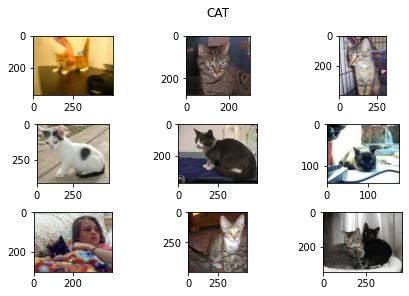

In [6]:
folder = 'train/cat/'

fig, ax = plt.subplots(3,3, constrained_layout = True)
fig.suptitle('CAT')
for i in range(3):
  for j in range(3):
    filename = folder + 'cat.' + str((3*i)+j) + '.jpg'
    image = imread(filename)
    ax[i][j].imshow(image)

 

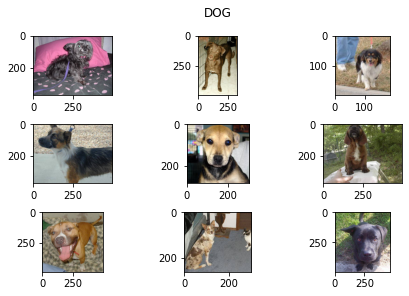

In [7]:
folder = 'train/dog/'

fig, ax = plt.subplots(3,3, constrained_layout = True)
fig.suptitle('DOG')

for i in range(3):
  for j in range(3):
    filename = folder + 'dog.' + str((3*i)+j) + '.jpg'
    image = imread(filename)
    ax[i][j].imshow(image)

## Splitting Data into 80% Train and 20% Val





In [8]:
!mkdir /content/dataset

root_dir = '/content/dataset/'
from_dir = '/content/train/'

splitfolders.ratio(from_dir, output=root_dir, seed=1337,
                    ratio=(.8, .2))

train_dir = '/content/dataset/train'
val_dir = '/content/dataset/val'

Copying files: 25000 files [00:06, 4074.65 files/s]


## Generator

In [9]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest')

original_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(
                    rescale=1./255)

## Data Augmentation

In [10]:
BATCH_SIZE = 128

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        seed = 888,
        class_mode='binary')

original_generator = original_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        seed = 888,
        class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode='binary')

NUM_TRAIN = train_generator.n
NUM_VAL = validation_generator.n

Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


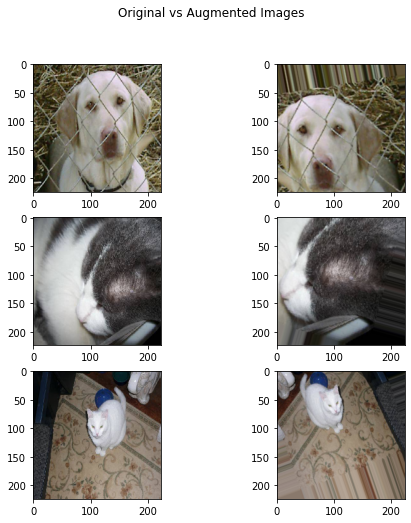

In [11]:
fig, ax = plt.subplots(3, 2, figsize = (8,8))
augmented_image, _ = train_generator[0]
original_image, _ = original_generator[0]

for i in range(3):
    ax[i][0].imshow(original_image[i])
    ax[i][1].imshow(augmented_image[i])

fig.suptitle("Original vs Augmented Images")
plt.show()

## **Designing and Training the model**

In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential

MobNet = MobileNetV2(include_top=False, input_shape=(224,224,3))
MobNet.trainable = False

model = Sequential()

model.add(MobNet)
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(1, activation="sigmoid"))

model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 8)           92168     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 8)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                           

In [14]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adamax(), # Optimizer Adamax
              metrics=['accuracy'])

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2
)

In [15]:
history = model.fit(train_generator,
                    steps_per_epoch=NUM_TRAIN // BATCH_SIZE,
                    epochs=5,
                    validation_data=validation_generator,
                    validation_steps=NUM_VAL // BATCH_SIZE,
                    callbacks=[earlystop],
                    verbose=1)

Epoch 1/5
156/156 [==============================] - 311s 2s/step - loss: 0.2189 - accuracy: 0.9072 - val_loss: 0.0645 - val_accuracy: 0.9760
Epoch 2/5
156/156 [==============================] - 296s 2s/step - loss: 0.1239 - accuracy: 0.9509 - val_loss: 0.0508 - val_accuracy: 0.9818
Epoch 3/5
156/156 [==============================] - 296s 2s/step - loss: 0.1099 - accuracy: 0.9570 - val_loss: 0.0469 - val_accuracy: 0.9832
Epoch 4/5
156/156 [==============================] - 293s 2s/step - loss: 0.1026 - accuracy: 0.9598 - val_loss: 0.0481 - val_accuracy: 0.9826
Epoch 5/5
156/156 [==============================] - 291s 2s/step - loss: 0.0995 - accuracy: 0.9599 - val_loss: 0.0503 - val_accuracy: 0.9824


## **Plotting the train and validation metrics**

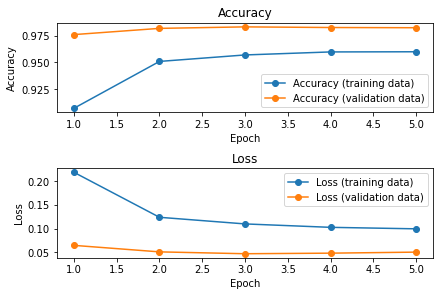

In [16]:
fig, ax = plt.subplots(2, constrained_layout=True)
ax[0].plot(range(1, 6), history.history['accuracy'], label='Accuracy (training data)', marker='o')
ax[0].plot(range(1, 6), history.history['val_accuracy'], label='Accuracy (validation data)', marker='o')
ax[0].set_title('Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(loc="lower right")

ax[1].plot(range(1, 6), history.history['loss'], label='Loss (training data)', marker='o')
ax[1].plot(range(1, 6), history.history['val_loss'], label='Loss (validation data)', marker='o')
ax[1].set_title('Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(loc="upper right")

plt.show()

## **Result**

In [17]:
y_pred = model.predict(validation_generator)

In [18]:
print("Confussion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred.round()))
print("\nClassification Report")
print(classification_report(validation_generator.classes, y_pred.round(), target_names=['cat', 'dog']))

Confussion Matrix
[[2433   67]
 [  21 2479]]

Classification Report
              precision    recall  f1-score   support

         cat       0.99      0.97      0.98      2500
         dog       0.97      0.99      0.98      2500

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



## **Save TF-Lite**

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite','wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmphb2jp_wt/assets


INFO:tensorflow:Assets written to: /tmp/tmphb2jp_wt/assets
